## Dataset importing using Kaggle API


In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

In [ ]:
!unzip '/content/cat-and-dog.zip'

## Import Packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
import os

## Explore the Data

In [8]:
train = '/content/training_set/training_set/'
val = '/content/test_set/test_set/'

Categories = [x for x in os.listdir(train)]
print(Categories)

['dogs', 'cats']


[8007, 2025]


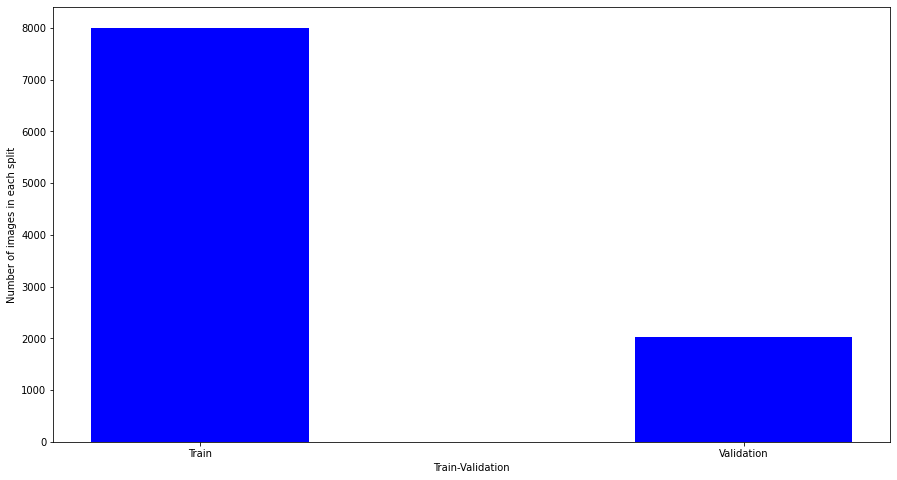

In [11]:
train_total = 0
test_total = 0
val_total = 0

for i in Categories:
  train_total += len(os.listdir(train + i))
  #test_total += len(os.listdir(test + i))
  val_total += len(os.listdir(val + i))

div = ['Train', 'Validation']

values = [train_total, val_total]

print(values)

fig = plt.figure(figsize = (15, 8)) 
  
# creating the bar plot 
plt.bar(div, values, color ='blue',  
        width = 0.4)  
plt.xlabel("Train-Validation") 
plt.ylabel("Number of images in each split") 
plt.show() 

## Data Preprocessing with augmentation

In [12]:
TRAINING_DIR = train
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
VALIDATION_DIR = val
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224,224),
    batch_size = 32,
    shuffle = True,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224,224),
    batch_size = 16,
    shuffle = True,
    class_mode='categorical')

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## Building Model - Transfer Learning

In [40]:
# Create the base model from the pre-trained model VGG16
IMG_SIZE = (224, 224)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [41]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [42]:
base_model.trainable = False

In [43]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [45]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax') # As the number of classes is 225
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [46]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [57]:
base_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


## Tensorboard

In [49]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [50]:
import datetime
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [51]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training

In [59]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_generator)

127/127 [==============================] - 8s 60ms/step - loss: 0.6899 - accuracy: 0.5522


In [60]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.55


In [61]:
es = EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='min'
)

In [62]:
mc = ModelCheckpoint('best_eff_b7_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [63]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks = [es, mc])

Epoch 1/100
251/251 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5305
Epoch 00001: val_accuracy improved from -inf to 0.55264, saving model to best_eff_b7_model.h5
251/251 [==============================] - 104s 416ms/step - loss: 0.6904 - accuracy: 0.5305 - val_loss: 0.6868 - val_accuracy: 0.5526
Epoch 2/100
251/251 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5375
Epoch 00002: val_accuracy improved from 0.55264 to 0.56945, saving model to best_eff_b7_model.h5
251/251 [==============================] - 104s 416ms/step - loss: 0.6884 - accuracy: 0.5375 - val_loss: 0.6843 - val_accuracy: 0.5695
Epoch 3/100
251/251 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5434
Epoch 00003: val_accuracy improved from 0.56945 to 0.57538, saving model to best_eff_b7_model.h5
251/251 [==============================] - 104s 415ms/step - loss: 0.6872 - accuracy: 0.5434 - val_loss: 0.6821 - val_accuracy: 0.5754
Epoch 4/100
251/

## Evaluating Accuracy and Loss for the Model

Text(0.5, 1.0, 'Training and Validation Accuracy')

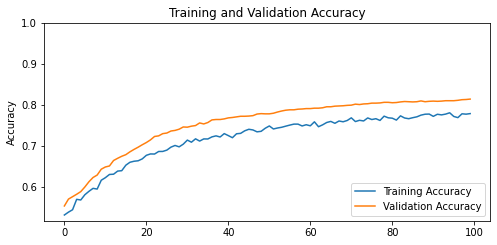

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

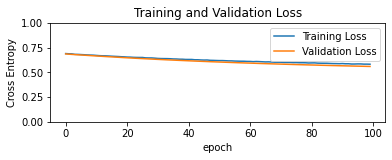

In [65]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [66]:
base_model.trainable = True

In [67]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [68]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [70]:
len(model.trainable_variables)

2

In [71]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks = [tensorboard_callback])

model.save('/content/best_eff_b7_model.h5')

Epoch 100/110
  1/251 [..............................] - ETA: 0s - loss: 0.5684 - accuracy: 0.7500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
251/251 [==============================] - 105s 420ms/step - loss: 0.5814 - accuracy: 0.7779 - val_loss: 0.5600 - val_accuracy: 0.8141
Epoch 101/110
251/251 [==============================] - 105s 419ms/step - loss: 0.5837 - accuracy: 0.7708 - val_loss: 0.5599 - val_accuracy: 0.8141
Epoch 102/110
251/251 [==============================] - 106s 421ms/step - loss: 0.5815 - accuracy: 0.7818 - val_loss: 0.5598 - val_accuracy: 0.8141
Epoch 103/110
251/251 [==============================] - 105s 418ms/step - loss: 0.5825 - accuracy: 0.7813 - val_loss: 0.5598 - val_accuracy: 0.8141
Epoch 104/110
251/251 [===================

In [72]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

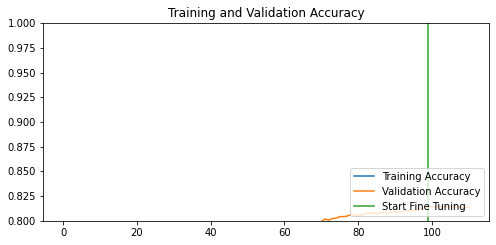

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

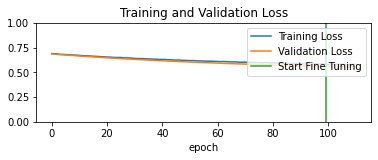

In [74]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

### We can see fine-tuning did not improve the accuracy of the EfficientNet B7 model.

## Running the Model

In [ ]:
# load all images into a list
images = []
img_folder = os.path.join('/content/test/')
img_files = os.listdir(img_folder)
img_files = [os.path.join(img_folder, f) for f in img_files]
# print(img_files)
for img in img_files:
    img = load_img(img, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
# print(images)
classes = model.predict_classes(images, batch_size=8)
print(classes)